In [1]:
import os
import tensorflow as tf 
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

2023-12-15 10:52:44.842883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 10:52:45.029205: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-15 10:52:45.889199: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.3/lib64
2023-12-15 10:52:45.889301: W te

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = False
with tf.compat.v1.Session(config=config) as sess:

    # 메모리 40% 할당
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.001
    sess = tf.compat.v1.Session(config=config)

2023-12-15 10:52:46.889098: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 10:52:47.809909: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 77951 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0
2023-12-15 10:52:47.828960: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 77951 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


In [3]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import Accuracy

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=2000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = float(step+10)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return 1000 * tf.math.minimum(arg1, arg2)

temp_learning_rate_schedule = CustomSchedule(256,1000000)
callback = tf.keras.callbacks.LearningRateScheduler(temp_learning_rate_schedule, verbose=0)

2023-12-15 10:52:48.139806: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 77951 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


In [4]:
import numpy as np
tf.multiply(tf.reduce_sum(tf.one_hot([[1,2]]*100,200),axis=1),[[1,0]*100]*100)

<tf.Tensor: shape=(100, 200), dtype=float32, numpy=
array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)>

In [5]:
temp_learning_rate_schedule(15)

<tf.Tensor: shape=(), dtype=float32, numpy=2.5000001e-05>

In [6]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,mask_zero=True)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim,mask_zero = True)

    def call(self, x):
        positions = np.array([0]+[0]+[i+2 for i in range(198)])
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions    
    
    
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        l2_reg = tf.keras.regularizers.l2(0.01)
        
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim,kernel_regularizer=l2_reg)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs,attention_mask=tf.cast(np.array([[1]+[0]+[1]*198] + [[0]+[1]*199] + [[0]*2+[1]*198]*198),bool))
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    
    
    
class BERT(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim):
        super(BERT, self).__init__()
        self.encoder = tf.keras.Sequential([TransformerBlock(emb_dim,num_heads,ff_dim) for i in range(8)])
        
        self.embedding = TokenAndPositionEmbedding(200,3500,256)
        self.dense = tf.keras.layers.Dense(250,activation = 'gelu')
        self.classify = tf.keras.layers.Dense(732,activation = 'softmax')
    def call(self, inputs, mask_index,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
        
        inputs = tf.reshape(inputs,[-1,200])
        hidden = self.embedding(inputs)
        
        
        hidden = self.encoder(hidden)
    
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = self.dense(output)
            output = layers.Dropout(0.1)(output)
            output = self.classify(output)
            output = tf.boolean_mask(output,boolean_mask)
            return output
        else:
            return hidden

In [7]:
from tensorflow.keras import layers
class BERT_all(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim,vocab_num=1300):
        super(BERT_all, self).__init__()
        self.transform_block = TransformerBlock(emb_dim,num_heads,ff_dim)
        self.embedding = TokenAndPositionEmbedding(200,vocab_num,256)
        self.dense = tf.keras.layers.Dense(250,activation = 'gelu')
        self.classify = tf.keras.layers.Dense(1300,activation = 'softmax')
        
    def call(self, inputs, mask_index,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
        hidden = self.embedding(inputs)
        for i in range(8):
            hidden = self.transform_block(hidden)
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = tf.boolean_mask(output,boolean_mask)
            output = self.dense(output)
            output = tf.keras.layers.Dropout(0.1)(output)
            output = self.classify(output)
            return output
        else:
            return hidden

In [8]:

class BERT_norm(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim):
        super(BERT_norm, self).__init__()
        self.transform_block_trainable = TransformerBlock(emb_dim,num_heads,ff_dim)
        self.transform_block = TransformerBlock(emb_dim,num_heads,ff_dim)
        self.transform_block.trainable = False
        self.embedding = TokenAndPositionEmbedding(200,3500,256)
        self.dense = layers.Dense(250,activation = 'gelu')
        self.classify = layers.Dense(661,activation = 'softmax')
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    def call(self, inputs, mask_index,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
        hidden = self.embedding(inputs)

        for i in range(8):
            hidden = self.transform_block(hidden)
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = tf.boolean_mask(output,boolean_mask)
            output = self.dense(output)
            output = layers.Dropout(0.1)(output)
            output = self.classify(output)
            return output
        else:
            return hidden

In [9]:
from rdkit import Chem
from tqdm import tqdm
def Chem_generator(smiles,tox_info):
    res_list = []
    res_tox_info = []
    for index1,i in tqdm(enumerate(smiles)):
        mol = Chem.MolFromSmiles(i)
        temp = []
        index = 0
        while(len(set(temp))!=20 and index != 100):
            index+=1
            temp.append(Chem.MolToSmiles(mol,doRandom=True))
        res_list+=list(set(temp))
        res_tox_info+=[tox_info[index1]]*len(list(set(temp)))
    return res_list,res_tox_info

In [10]:
def Chem_generator_val(smiles):
    res_list = []
    len_list = []
    for i in tqdm(smiles):
        mol = Chem.MolFromSmiles(i)
        temp = []
        index = 0
        while(len(set(temp))!=20 and index != 100):
            index+=1
            temp.append(Chem.MolToSmiles(mol,doRandom=True))
        res_list+=list(set(temp))
        len_list.append(len(list(set(temp))))
    return res_list,len_list

In [11]:
def predict(model,results,len_list):
    index = 0
    res = model.predict(results,verbose=0)
    result_list = []
    for i in len_list:
        temp = res[index:index+i]
        result_list.append(np.average(temp,axis=0))
        index = index+i
    return np.array(result_list)

In [12]:
inputs = Input(shape = (200,),dtype=tf.int32)
mask = Input(shape = (16), dtype=tf.int32)
outputs = BERT(256,6,1024)(inputs,mask,pretrain=True)

model = Model(inputs = [inputs,mask], outputs = [outputs])
model.summary()

model.load_weights('./BERT/atomInSmile/F_Random_ZINC_L_model_weights.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 bert (BERT)                    (None, 732)          18029742    ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
Total params: 18,029,742
Trainable params: 18,029,742
Non-trainable params: 0
________________

In [13]:
BERT_parameters = model.get_weights()[:130]

In [14]:

auc = AUC(name='auc')
acc = Accuracy(name = 'acc')
inputs = Input(shape = (200,),dtype=tf.int32)
bert_layer = BERT(256,6,1024)

hidden = bert_layer(inputs,None)

hidden1 = hidden[:,0]
output = tf.keras.layers.Dense(256,activation = 'gelu')(hidden1)
output = tf.keras.layers.Dense(1,activation = 'sigmoid')(output)

BERT_Classifier = Model(inputs = [inputs], outputs=[output])


BERT_Classifier.layers[1].set_weights(BERT_parameters)
BERT_Classifier.compile(optimizer='Adam',loss = 'binary_crossentropy',metrics=['acc',auc])
BERT_Classifier.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 bert_1 (BERT)               (None, 200, 256)          17781760  
                                                                 
 tf.__operators__.getitem (S  (None, 256)              0         
 licingOpLambda)                                                 
                                                                 
 dense_36 (Dense)            (None, 256)               65792     
                                                                 
 dense_37 (Dense)            (None, 1)                 257       
                                                                 
Total params: 17,847,809
Trainable params: 17,847,809
Non-trainable params: 0
_______________________________________________

In [15]:
inputs = Input(shape = (200,),dtype=tf.int32)
hidden = bert_layer(inputs,None)
hidden1 = hidden[:,1]
output = tf.keras.layers.Dense(256,activation = 'gelu')(hidden1)
output = tf.keras.layers.Dense(1)(output)
BERT_Regression = Model(inputs = [inputs], outputs=[output])
BERT_Regression.compile(optimizer='Adam',loss = 'mse')
BERT_Regression.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200)]             0         
                                                                 
 bert_1 (BERT)               (None, 200, 256)          17781760  
                                                                 
 tf.__operators__.getitem_1   (None, 256)              0         
 (SlicingOpLambda)                                               
                                                                 
 dense_38 (Dense)            (None, 256)               65792     
                                                                 
 dense_39 (Dense)            (None, 1)                 257       
                                                                 
Total params: 17,847,809
Trainable params: 17,847,809
Non-trainable params: 0
_______________________________________________

In [16]:
with open('./BERT/atomInSmile/1M_random_ZINC_word2index.pkl','rb') as file:
    word2idx = pickle.load(file)
from difflib import SequenceMatcher
def similar(a, b):    return SequenceMatcher(None, a, b).ratio()
def most_similar(query):

    max = 0
    tokken = ''
    query = query.split(';')
    for i in word2idx.keys():
        key = i.split(';')
        temp2 = 0
        temp3 = 0
        temp1 = similar(query[0],key[0])*10
        try:
            temp2 = similar(query[1],key[1])*2
            temp3 = similar(query[2],key[2])*1
        except:
            pass
        temp = temp1+temp2+temp3
        if temp>max:
            max = temp
            tokken = i
    return tokken

In [17]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, result_list,y_true,len_20):
        super().__init__()
        self.result_list = result_list
        index = 0
        res = []
        for i in len_20:
            res.append(np.average(y_true[index:index+i]))
            index = index+i
        self.len20 = len_20
        self.counts = []
        self.max = 0
        self.y_true = np.array(res)
        self.history = {}
        self.epoch = 0
    def on_epoch_end(self, epoch, logs=None):
        # 에포크가 끝날 때마다 validation 데이터로 모델 평가
        result = predict(self.model,self.result_list,self.len20)
        acc = accuracy_score(self.y_true,np.round(result))
        auc_res = roc_auc_score(self.y_true,result)
        loss = tf.keras.metrics.BinaryCrossentropy()(self.y_true,result)
        auc_res = auc_res
        print(f"     val_acc : {acc},    val_auc : {auc_res} val_loss : {loss}")
        if 'val_acc' not in self.history:
            self.history['val_acc'] = [acc]
        else:
            self.history['val_acc'] += [acc]
        if 'val_auc' not in self.history:
            self.history['val_auc'] = [auc_res]
        else:
            self.history['val_auc'] += [auc_res]
        
        if 'val_loss' not in self.history:
            self.history['val_loss'] = [loss]
        else:
            self.history['val_loss'] += [loss]
        
        self.max = np.max(self.history['val_auc'])
            
        if self.history['val_auc'][-1]<self.max:
            self.counts.append(1)
        else:
            self.counts = []

        self.epoch += 1
        
        if self.epoch>5 and len(self.counts)>2:
            self.model.stop_training = True

In [18]:
from sklearn.model_selection import train_test_split


tox_name = 'AMES'

with open('./AIS_Tox_data/'+tox_name,'rb') as file:
    train,label,len_20 = pickle.load(file)[0] 
with open('./BERT/atomInSmile/1M_random_ZINC_word2index.pkl','rb') as file:
    word2idx = pickle.load(file)

In [19]:
except_dict = {}

for i in train:
    for j in i:
        try:
            word2idx[j]
        except:
            try:
                except_dict[j]
            except:
                except_dict[j] = len(except_dict) + 1

<BarContainer object of 110 artists>

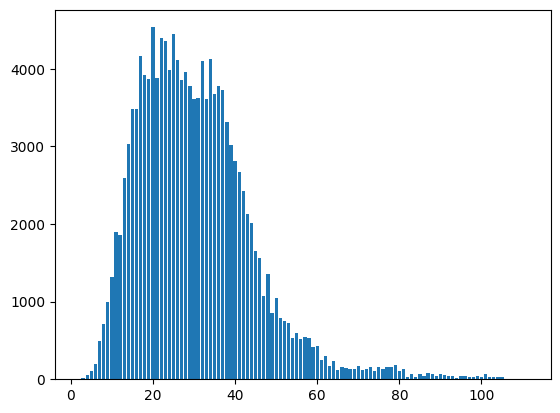

In [20]:
temp_dict = {}

for i in train:
    try:
        temp_dict[len(i)] = temp_dict[len(i)] + 1
    except:
        temp_dict[len(i)] = 1
        
plt.bar(temp_dict.keys(),temp_dict.values())

In [21]:
Full_dict = {}
for i in train:
    for j in i:
        try:
            except_dict[j]
            Full_dict[j] = Full_dict[j]+1
        except:
            Full_dict[j] = 1
        

In [22]:
for i in except_dict.keys():
    if Full_dict[i]>5:
        print(i,Full_dict[i])

9 14
[P;!R;COSS] 40
[S;!R;CP] 820
[S;!R;P] 973
[P;!R;OOOS] 514
[CH2;!R;ClO] 6
[C;!R;CClO] 490
[O;!R;CO] 752
[CH2;!R;ClN] 56
[N;!R;COO] 640
[N;!R;OO] 114
[C;!R;ClClFS] 20
[P;!R;OOSS] 520
[PH;R;CCNN] 60
[n;R;CCCl] 100
[C;!R;NS] 149
[O;R;CO] 760
[OH;!R;O] 314
[P;!R;NOOS] 60
[CH;!R;BrCCl] 152
[CH;!R;CClO] 20
[S;!R;CClOO] 60
[Cl;!R;S] 70
[[O-];!R;Cl] 20
[N;!R;NNO] 40
[CH;!R;ClClN] 19
[CH2;!R;CI] 153
[CH;!R;BrBrCl] 6
[[cH-];R;NN] 20
[P;!R;CFOO] 40
[F;!R;P] 40
[CH;!R;BrBrC] 165
[[N+];!R;CO] 40
[C;!R;BrClClCl] 8
[[P+];!R;NNNO] 20
[C;!R;ClClClN] 20
[F;!R;S] 20
[S;!R;FOOO] 20
[C;!R;CCClO] 40
[CH;!R;CClF] 80
[[CH-];!R;CN] 56
[P;R;OOOS] 20
[CH;R;CClO] 44
[P;!R;COOS] 20
[C;!R;BrClFF] 20
[N;!R;OS] 50
[O;!R;NO] 20
[P;!R;NNNS] 39
[Cl;!R;P] 78
[P;!R;ClOOS] 20
[P;!R;NNNO] 39
[N;!R;CCCl] 20
[C;!R;ClClClF] 8
[CH2;!R;ClS] 66
[C;!R;ClOO] 60
[C;!R;NP] 20
[C;!R;ClOS] 40
[C;!R;CClClN] 20
[[CH2-];!R;N] 12
[PH;R;NNNN] 60
[C;!R;NNNN] 20
[CH;R;CCI] 20
[P;!R;CClOO] 20
[S;!R;CCl] 10
[C;!R;ClNO] 20
[N;!R;ClClS] 20
[C

In [23]:
from difflib import SequenceMatcher
def similar(a, b):    return SequenceMatcher(None, a, b).ratio()

In [24]:
def most_similar(query):

    max = 0
    tokken = ''
    query = query.split(';')
    for i in word2idx.keys():
        key = i.split(';')
        temp2 = 0
        temp3 = 0
        temp1 = similar(query[0],key[0])*10
        try:
            temp2 = similar(query[1],key[1])*2
            temp3 = similar(query[2],key[2])*1
        except:
            pass
        temp = temp1+temp2+temp3
        if temp>max:
            max = temp
            tokken = i
    return tokken

In [25]:
similar_dict = {}

for i in except_dict.keys():
    similar_dict[i] = most_similar(i)

In [26]:
### Data processing

AIS_train = []
for index,i in enumerate(train):
    temp = []
    temp.append(3)
    temp.append(4)
    temp.append(1)
    for j in i:
        try:
            temp.append(word2idx[j])
        except:
            if j != '/[H]':
                word_sim = similar_dict[j]
                if word_sim != '':
                    temp.append(word2idx[word_sim])
            else:
                pass
    if len(temp)>1:
        AIS_train.append(temp)

AIS_train = tf.keras.preprocessing.sequence.pad_sequences(AIS_train, padding='post', maxlen=200)


In [27]:
temp_x = []
temp_y = []
index = 0
for i in len_20:
    temp_x.append(AIS_train[index:index+i])
    temp_y.append(label[index:index+i])
    index = index+i



x_train, x_val, y_train, y_val,_,len_20 = train_test_split(temp_x,temp_y,len_20, test_size=0.2)

x_val,x_test,y_val,y_test,len_20,len_20_test = train_test_split(x_val,y_val,len_20, test_size=0.5)

temp = []
for i in x_train:
    temp+=list(i)
x_train = np.array(temp)

temp = []
for i in x_val:
    temp+=list(i)
x_val = np.array(temp)

temp = []
for i in y_train:
    temp+=list(i)
y_train = np.array(temp)

temp = []
for i in y_val:
    temp+=list(i)
y_val = np.array(temp)

temp = []
for i in x_test:
    temp+=list(i)
x_test = np.array(temp)

temp = []
for i in y_test:
    temp+=list(i)
y_test = np.array(temp)


In [28]:
len(x_train),len(x_test),len(x_val),len(len_20),len(len_20_test)

(111917, 13969, 14017, 728, 728)

In [29]:

def R2(y,y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y,y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y,tf.reduce_mean(y))))
    r2 = tf.subtract(1.0,tf.div(residual,total))
    return r2


In [30]:
from tensorflow.keras.optimizers import Adam
BERT_Classifier.compile(loss = 'binary_crossentropy',optimizer=Adam(learning_rate=1e-5),metrics=['acc',AUC(name='auc')])
BERT_Regression.compile(loss = 'mean_squared_error',optimizer=Adam(learning_rate=1e-5),metrics=[R2])

In [31]:

val_call = CustomCallback(x_val,y_val,len_20)


In [37]:
BERT_Classifier(x_train[:100])

<tf.Tensor: shape=(100, 1), dtype=float32, numpy=
array([[0.85075915],
       [0.8731875 ],
       [0.8526602 ],
       [0.8378214 ],
       [0.8312189 ],
       [0.8782137 ],
       [0.8719721 ],
       [0.84491277],
       [0.8282075 ],
       [0.84795487],
       [0.8337766 ],
       [0.86060476],
       [0.8591571 ],
       [0.8731875 ],
       [0.8399594 ],
       [0.8501297 ],
       [0.8231286 ],
       [0.8312189 ],
       [0.86002445],
       [0.8337766 ],
       [0.6255892 ],
       [0.4600533 ],
       [0.51678336],
       [0.64595497],
       [0.5967802 ],
       [0.5322724 ],
       [0.40328145],
       [0.7093492 ],
       [0.7049739 ],
       [0.6562772 ],
       [0.56150186],
       [0.58549786],
       [0.4533524 ],
       [0.4206478 ],
       [0.5833916 ],
       [0.69428545],
       [0.5221246 ],
       [0.5853148 ],
       [0.4294922 ],
       [0.7355009 ],
       [0.7592584 ],
       [0.790458  ],
       [0.80850023],
       [0.76249653],
       [0.791494  ],
     

In [56]:
roc_auc_score(y_train[:400],BERT_Classifier(x_train[:400])),(AUC()(y_train[:400],BERT_Classifier(x_train[:400]))).numpy()

(0.752101645718667, 0.75230706)

: 

In [55]:
accuracy_score(y_train[:300],np.round(BERT_Classifier(x_train[:300]))),(Accuracy()(y_train[:300],np.round(BERT_Classifier(x_train[:300])))).numpy()

(0.5366666666666666, 0.5366667)

In [47]:
AUC()(y_train[:200],BERT_Classifier(x_train[:200]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.6044643>

In [706]:
from tensorflow.keras.optimizers import Adam
BERT_Classifier.compile(loss = 'binary_crossentropy',optimizer=Adam(learning_rate=1e-5),metrics=['acc',AUC(name='auc')])

with tf.device('/device:GPU:0'):
    temp_history = BERT_Classifier.fit(x_train,np.array(y_train),epochs=20,batch_size=32,callbacks=[val_call])

Epoch 1/20


3495/3495 [==============================] - 316s 85ms/step - loss: 0.6296 - acc: 0.7397 - auc: 0.8127
Epoch 2/20
3495/3495 [==============================] - 291s 83ms/step - loss: 0.5366 - acc: 0.8028 - auc: 0.8729
Epoch 3/20
3495/3495 [==============================] - 293s 84ms/step - loss: 0.4975 - acc: 0.8195 - auc: 0.8918
Epoch 4/20
3495/3495 [==============================] - 291s 83ms/step - loss: 0.4683 - acc: 0.8325 - auc: 0.9049
Epoch 5/20
3495/3495 [==============================] - 294s 84ms/step - loss: 0.4449 - acc: 0.8426 - auc: 0.9146
Epoch 6/20
3495/3495 [==============================] - 294s 84ms/step - loss: 0.4246 - acc: 0.8505 - auc: 0.9227
Epoch 7/20
 238/3495 [=>............................] - ETA: 4:20 - loss: 0.4029 - acc: 0.8642 - auc: 0.9315

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
inputs = Input(shape=(2048,),name='input')
outputs = Dense(250,activation = 'relu')(inputs)
outputs = Dropout(0.3)(outputs)
outputs = Dense(40,activation = 'relu')(outputs)
outputs = Dropout(0.3)(outputs)
outputs = Dense(10,activation = 'relu')(outputs)
outputs = Dropout(0.3)(outputs)
outputs = Dense(1,activation = 'sigmoid')(outputs)

model_NN = Model(inputs= [inputs], outputs=[outputs])
model_NN.summary()

Model: "model_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2048)]            0         
                                                                 
 dense_612 (Dense)           (None, 250)               512250    
                                                                 
 dropout_484 (Dropout)       (None, 250)               0         
                                                                 
 dense_613 (Dense)           (None, 40)                10040     
                                                                 
 dropout_485 (Dropout)       (None, 40)                0         
                                                                 
 dense_614 (Dense)           (None, 10)                410       
                                                                 
 dropout_486 (Dropout)       (None, 10)                0  

                                                                 
 dense_615 (Dense)           (None, 1)                 11        
                                                                 
Total params: 522,711
Trainable params: 522,711
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
class CustomCallback_NN(tf.keras.callbacks.Callback):
    def __init__(self, result_list,y_true):
        super().__init__()
        self.result_list = result_list
        index = 0
        self.len20 = len_20
        self.counts = []
        self.max = 0
        self.y_true = y_true
        self.history = {}
        self.epoch = 0
    def on_epoch_end(self, epoch, logs=None):
        # 에포크가 끝날 때마다 validation 데이터로 모델 평가
        result = self.model.predict(self.result_list)
        acc = accuracy_score(self.y_true,np.round(result))
        auc_res = roc_auc_score(self.y_true,result)
        loss = tf.keras.metrics.BinaryCrossentropy()(self.y_true,result)
        auc_res = auc_res
        print(f"     val_acc : {acc},    val_auc : {auc_res} val_loss : {loss}")
        if 'val_acc' not in self.history:
            self.history['val_acc'] = [acc]
        else:
            self.history['val_acc'] += [acc]
        if 'val_auc' not in self.history:
            self.history['val_auc'] = [auc_res]
        else:
            self.history['val_auc'] += [auc_res]
        
        if 'val_loss' not in self.history:
            self.history['val_loss'] = [loss]
        else:
            self.history['val_loss'] += [loss]
        
        self.max = np.max(self.history['val_auc'])
            
        if self.history['val_auc'][-1]<self.max:
            self.counts.append(1)
        else:
            self.counts = []

        self.epoch += 1
        
        if self.epoch>5 and len(self.counts)>2:
            self.model.stop_training = True

In [ ]:
from tdc.single_pred import Tox
from Module import RDK
train,tox_info = Tox(name=tox_name).get_data(format='DeepPurpose')
bit_string = RDK.smile_to_RDkit(train,2048)
x_train_NN,x_val_NN,y_train_NN,y_val_NN = train_test_split(np.array(bit_string)/1.,np.array(tox_info)/1.,test_size=0.2)
x_val_NN,x_test_NN,y_val_NN,y_test_NN = train_test_split(x_val_NN,y_val_NN, test_size=0.5)

val_call_NN = CustomCallback_NN(x_val_NN,y_val_NN)

model_NN.compile(loss = 'binary_crossentropy',optimizer='Adam',metrics=['acc',AUC(name = 'auc')])
model_NN.fit(x_train_NN,y_train_NN,epochs=20,callbacks=[val_call_NN],batch_size=20)

Found local copy...
Loading...
Done!
[20:34:28] WARNING: not removing hydrogen atom without neighbors
[20:34:28] WARNING: not removing hydrogen atom without neighbors


Epoch 1/20
3/3 [==============================] - 0s 3ms/step loss: 0.6778 - acc: 0.5360 - auc: 0.51
     val_acc : 0.7230769230769231,    val_auc : 0.6836734693877551 val_loss : 0.5880955457687378
27/27 [==============================] - 2s 15ms/step - loss: 0.6738 - acc: 0.5477 - auc: 0.5258
Epoch 2/20
3/3 [==============================] - 0s 3ms/step loss: 0.5565 - acc: 0.7140 - auc: 0.71
     val_acc : 0.7230769230769231,    val_auc : 0.7206632653061225 val_loss : 0.6230372786521912
27/27 [==============================] - 0s 13ms/step - loss: 0.5541 - acc: 0.7137 - auc: 0.7248
Epoch 3/20
3/3 [==============================] - 0s 3ms/step loss: 0.4784 - acc: 0.7800 - auc: 0.82
     val_acc : 0.6923076923076923,    val_auc : 0.7308673469387756 val_loss : 0.656502902507782
27/27 [==============================] - 0s 13ms/step - loss: 0.4768 - acc: 0.7824 - auc: 0.8306
Epoch 4/20
3/3 [==============================] - 0s 3ms/step loss: 0.3783 - acc: 0.8519 - auc: 0.90
     val_acc : 

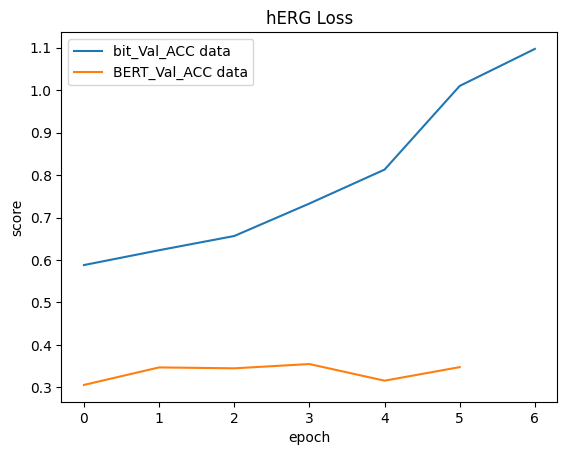

In [ ]:
plt.plot([i for i in range(len(val_call_NN.history['val_loss']))],val_call_NN.history['val_loss'],label='bit_Val_ACC data')
plt.plot([i for i in range(len(val_call.history['val_loss']))],val_call.history['val_loss'],label = 'BERT_Val_ACC data')
#plt.plot([i for i in range(len(val_call2.history['val_loss']))],val_call2.history['val_loss'],label = 'BERT_Norm acc data')
plt.title(tox_name + ' Loss')
plt.xlabel('epoch')
plt.ylabel('score')

plt.legend()

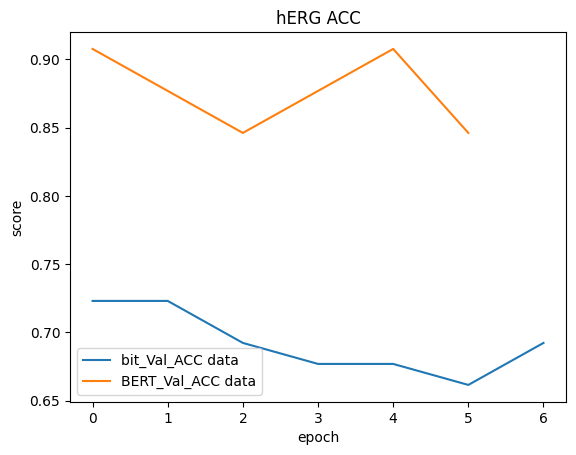

In [ ]:
plt.plot([i for i in range(len(val_call_NN.history['val_acc']))],val_call_NN.history['val_acc'],label='bit_Val_ACC data')
plt.plot([i for i in range(len(val_call.history['val_acc']))],val_call.history['val_acc'],label = 'BERT_Val_ACC data')
#plt.plot([i for i in range(len(val_call2.history['val_acc']))],val_call2.history['val_acc'],label = 'BERT_Norm acc data')
plt.title(tox_name + ' ACC')
plt.xlabel('epoch')
plt.ylabel('score')

plt.legend()


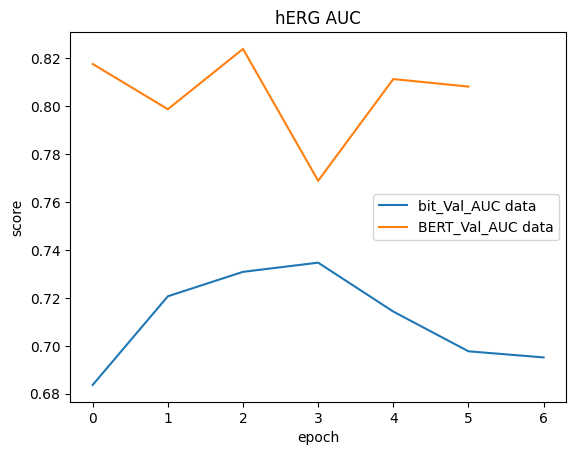

In [ ]:
plt.plot([i for i in range(len(val_call_NN.history['val_auc']))],val_call_NN.history['val_auc'],label='bit_Val_AUC data')
plt.plot([i for i in range(len(val_call.history['val_acc']))],val_call.history['val_auc'],label = 'BERT_Val_AUC data')
#plt.plot([i for i in range(len(val_call2.history['val_acc']))],val_call2.history['val_auc'],label = 'BERT_Norm data')
plt.title(tox_name + ' AUC')
plt.xlabel('epoch')
plt.ylabel('score')

plt.legend()

In [ ]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

temp = []
index = 0
for i in len_20_test:
    temp.append(np.average(y_test[index:index+i]))
    index = index+i
    

NN = model_NN(x_test_NN)
BERT_res = predict(BERT_Classifier,x_test,len_20_test)
print('Tox : ',tox_name)
print('Bit acc : ',(accuracy_score(np.round(NN),y_test_NN)))
print('Bit auc : ',(roc_auc_score(y_test_NN,NN)))
print('BERT acc : ',(accuracy_score(np.round(BERT_res),temp)))
print('BERT auc : ',(roc_auc_score(temp,BERT_res)))

3/3 [==============================] - 0s 3ms/step


Bit acc :  0.803030303030303
Bit auc :  0.8842391304347825
BERT acc :  0.803030303030303
BERT auc :  0.8243386243386244
